# Croisement des données 

##### *Claire Toffano-Nioche, I2BC, Paris-Saclay*

##### *Pauline Francois, Anses, Lyon*

##### *Selon les ressources de Matthias Zytnicki, INRAE, Toulouse*

##### *et toute la team Roscoff*

## Objectifs du cours

- Permettre de croiser des données génomiques de types différents
- Renforcer les notions vues précedemment
- Se familiariser avec <code>bedtools</code>

Ce que ce cours n'est pas :
- Une réponse à une vraie question biologique
- Une méthode statistiquement valide

## Croisement de données



#### Qu’est-ce c'est ?
- Une comparaison des positions ou intervalles génomiques: 
    - un variant par rapport à des gènes d’intérêt, 
    - des pics de ChIP-Seq par rapport à des gènes différentiellement exprimés, etc.

#### À quel moment est-ce valide ?
- Lorsque vous cherchez des co-occurrences
- Lorsque vous donnez des distributions (de distance)

#### À quel moment est-ce douteux ?
- Lorsque les résultats sont présentés comme significatifs.

## Renseignez les paramètres de votre réservation Jupyterlab

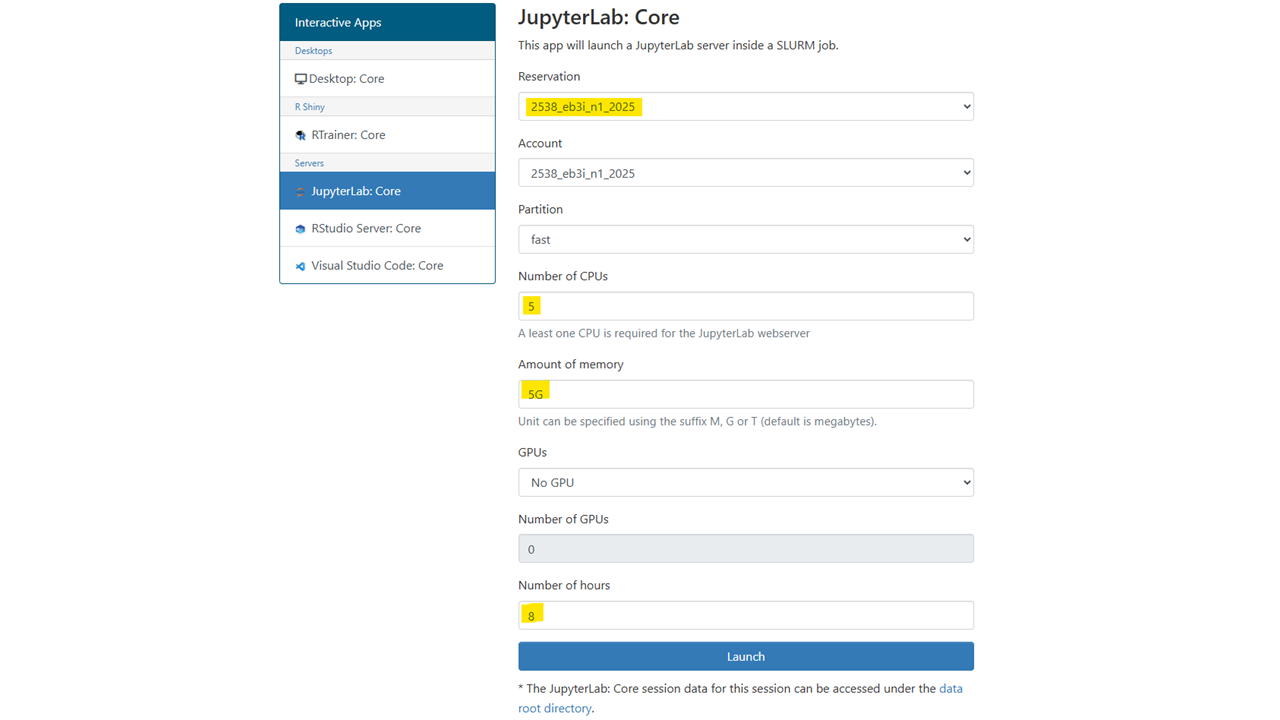"

## Avant de commencer

Rendez-vous dans votre espace projet et copier le dossier <code>/shared/projects/2538_eb3i_n1_2025/cours_commun/TP_croisement</code> et le mettre dans votre dossier <code>cours_commun</code>:


In [ ]:
cp -r /shared/projects/2538_eb3i_n1_2025/cours_commun/TP_croisement cours_commun/

Vérifier que vous êtes dans votre espace projet, sous-dossier TP_croisement

In [ ]:
# Afficher le chemin


#### Données disponibles
- Une liste de gènes différentiellement exprimés (Cellules avec un KO du gène beta-2-microglobulin, infectées par l'herpes simplex virus type 1 vs non infectées) (TXT)
- Une liste des sites de fixation de H3K4me3 déterminés par Chip-seq (BED)
- Une liste de variants (VCF)
- Un fichier d'annotation humain (GFF3)
- La liste des chromosomes humains et leur taille (LEN)

### Accès aux données du TP

1. Rendez vous dans le dossier <code>data/</code> et listez en le contenu

In [ ]:
# Se déplacer dans le dossier data

# Lister son contenu


Ce TP repose sur 4 jeux de données, issues d'analyses précédentes ainsi que sur les annotations du génome humain : 

- la longueur des chrs (et des contigs) de la version GRCh38 du génome humain (<code>chrs.len</code>)
- une liste de SNP variants (<code>variant.vcf</code>)
- une liste des identifiants de gènes différentiellement exprimés (<code>DEgenes.txt</code>)
- une liste des pics issus d'une analyse de ChIP-seq (<code>picChip.bed</code>), ici une marque d'histone h3k4me3
- les annotations correspondant aux gènes uniquement du génome humain GRCh38 (<code>hsGRCh38.genes.gff3</code>)

2. Afin de se familiariser avec le contenu des données, on affiche les 2 premières lignes de l'ensemble des fichiers :

In [ ]:
# Afficher les deux premières lignes de tous les fichiers


3. Pour le fichier variant.vcf on ne voit que des commentaires (souvent des lignes qui commencent par "#") ; afficher les deux dernières lignes de ce fichier :

In [ ]:
# Afficher les deux dernières lignes du fichier variant.vcf


4. Activer les outils bedtools (v2.30.0) et bc (1.07.1) dont nous aurons besoin plus loin

In [ ]:
# Charger les outils


## Problème

##### *Question scientifique*

Mes gènes différentiellement exprimés contiennent-ils plus de pics de chip qu'attendu ? (oui/non, pas de quantification)

En d'autres termes, y a-t-il plus ou moins de pics de chip-seq dans les gènes différentiellement exprimés par rapport aux gènes non différentiellement exprimés ?

##### *Données*
- DEgenes.txt
- picChip.bed
- hsGRCh38.genes.gff3


Afficher les trois premières lignes des fichiers <code>DEgenes.txt</code>, <code>picChip.bed</code> et <code>hsGRCh38.genes.gff3</code> :

In [ ]:
# Trois premières lignes des fichiers listés


<code>DEgenes.txt</code> est notre liste de gènes DE :

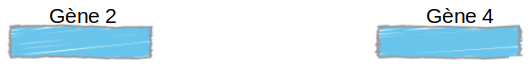


<code>picChip.bed</code> est notre liste de pics issus du chip-seq et positionnés sur le génome :

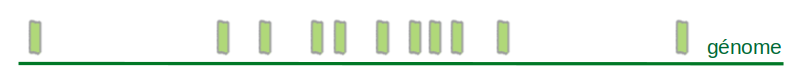

Pour croiser ces données il faut positionner les gènes DE sur le génome, on fait cela grâce au fichier d'annotation (gènes non DE plus clairs) :

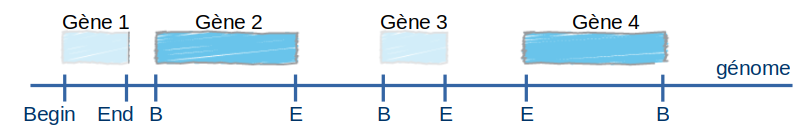

Le positionnement des données sur le génome permet maintenant de les croiser :

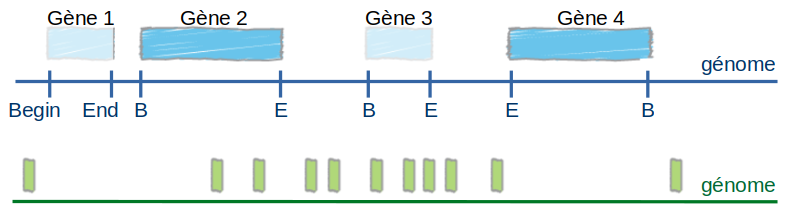

Le but sera de compter le nombre gène dans chacune des 4 classes possibles :

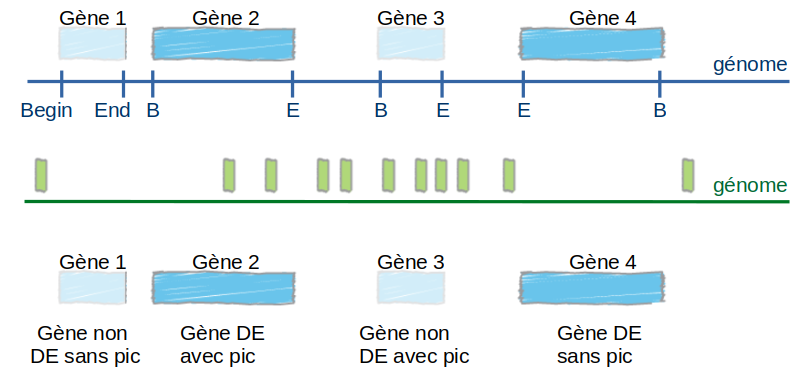

##### *Protocole envisagé*
<details><summary></summary>

  A. Extraire les intervalles génomiques des gènes différentiellement exprimés (DE)
    
  B. Comparer les intervalles génomiques des gènes DE avec les régions H3K4me3 (ie. l'emplacement des pics de chip-seq)
  
  C. Compter le nombre de chevauchements entre les gènes DE et les pics

  D. Trouver les intervalles génomiques des gènes non-différentiellement exprimés

  E. Comparer ces intervalles génomiques avec les régions H3K4me3

  F. Compter le nombre de chevauchements entre les gènes non DE et les pics

  G. Comparer les nombres de chevauchements

</details>

#### A. Extraire les intervalles génomiques des gènes différentiellement exprimés (DE)

1. Chercher (<code>grep</code>) une liste de mots (<code>-f</code>) contenue dans le fichier <code>DEgenes.txt</code> dans le fichier <code>hsGRCh38.genes.gff3</code> et rediriger la sortie standard dans un fichier nommé <code>DEgenes.gff3</code>

In [ ]:
# Rechercher les gènes contenus dans le fichier txt dans le fichier gff3


On peut vérifier ensuite que le nombre de gènes récupérés dans le fichier gff3 est celui attendu (nombre de gènes de notre liste). Sachant qu'une ligne = un gène, quelle commande pouvez vous exécuter ?

In [ ]:
# Compter le nombre de ligne de chacun des fichiers


Il est aussi possible de visualiser les 5 premières lignes de notre document nouvellement créé pour voir ce qu'il contient

In [ ]:
# Afficher les 5 premières lignes du fichier


#### B. Comparer les intervalles génomiques des gènes DE avec les régions H3K4me3 (ie. l'emplacement des pics de chip-seq)

Comme on va utiliser la suite d'outils que propose [Bedtools](https://bedtools.readthedocs.io/en/latest/content/bedtools-suite.html), avant tout, faisons un tour sur la documentation.

Chaque sous-commande fonctionne sur le même principe :

<code>bedtools [sub-command] [options]</code>

Les options varient selon la commande. Il suffit de cliquer sur son nom sur le site pour avoir accès à la fonction de la commande, à ses options et à des exemples.

Les trois qui nous intéresserons dans un premier temps sont [<code>intersect</code>](https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html), [<code>flank</code>](https://bedtools.readthedocs.io/en/latest/content/tools/flank.html) et [<code>closest</code>](https://bedtools.readthedocs.io/en/latest/content/tools/closest.html)(cliquez sur les sous-commandes pour voir leur aide)

Bedtools accepte quasiment tous les formats de fichiers tabulés (GFF3, BED, etc)

Dans notre cas de figure, nous souhaitons savoir si des gènes DE contiennent des pics et obtenir le nom de ces gènes. Nous utilisons donc la sous-commande "bedtools ....." ?

Le fichier A sera celui de l'annotation des gènes DE (<code>DEgenes.gff3</code>) et le B correspondra aux pics (<code>picChip.bed</code>). Quelle option choisir pour obtenir uniquement les annotations du fichier A qui croisent avec le fichier B ?

Rediriger la sortie standard dans un fichier nommé <code>intersect_DEgenes_picChip.gff3</code>

In [ ]:
# Intersection du fichier A et du fichier B


#### C. Compter le nombre de chevauchements entre les gènes DE et les pics

Nous avons obtenu la liste des gènes dans lesquels se trouvent des pics (<code>intersect_DEgenes_picChip.gff3</code>). Nous avons maintenant besoin de les compter.

In [ ]:
# Comptage des lignes


#### D. Trouver les intervalles génomiques des gènes non-différentiellement exprimés

<code>grep -v</code> : Chercher l'inverse d'une liste de gènes dans un texte et rediriger la sortie standard dans un fichier nommé <code>notDEgenes.gff3</code>

On récupère donc tous les gènes du fichier d'annotation <code>hsGRCh38.genes.gff3</code> dont le nom __n'est pas__ dans la liste des gènes DE <code>DEgenes.txt</code> puis on compte combien de gènes sont concernés.

In [ ]:
# Recherche inversée du contenu du fichier dans le gff3

# Comptage des lignes


#### E.  Comparer ces intervalles génomiques avec les régions H3K4me3
Faire l'intersection entre le fichier gff3 des gènes non DE et les pics de Chip-seq et écrire la sortie dans un fichier <code>intersect_notDEgenes_picChip.gff3</code>

In [ ]:
# Nouvel intersect mais avec le fichier de gène non DE

# Comptage des lignes


#### F. Compter le nombre de chevauchements entre les gènes non DE et les pics

Afin de pouvoir ensuite faire des ratios "nb de gène avec au moins un chevauchements/nb de gène" nous devons connaitre les valeurs suivantes :

- Nombre de gènes DE
- Nombre de gènes DE avec chevauchement
- Nombre de gènes non DE
- Nombre de gènes non DE avec chevauchement


In [ ]:
# Comptage des lignes de tous les fichiers


#### G. Comparer les nombres de chevauchements

Résumons nos informations :
 
 Ratios | avec pics | sans pic | total
-----------|----------|----------|-------
gene DE    |77        |162-77    |162
gene non DE|9438      |21330-9438|21330    
total      |          |          |21492



Par simple calcul de pourcentage nous obtenons le tableau suivant :

Ratios | avec pics | sans pic | total
-----------|----------|----------|-------
gene DE    |47.53%        | 52.47%    |162
gene non DE|44.24%      |55.76%|21330    
total      |          |          |21492

En conclusion : 
On peut noter une légère hausse du nombre de pics dans les gènes DE vs non DE.

/!\ En revanche on ne peut pas affirmer ou infirmer que cela soit significatif /!\

## Bonus n°1



##### *Question scientifique*

Quels sont les variants qui sont dans les promoteurs (2kb en amont du gène) des gènes différentiellement exprimés ?


##### *Données*
- DEgenes.gff3 (généré précédemment)
- variant.vcf
- chrs.len

Afficher les deux dernières lignes des fichiers <code>DEgenes.gff3</code>, <code>variant.vcf</code> et <code>chrs.len</code> :

In [ ]:
# Visualisation de la fin des fichiers


##### *Protocole envisagé*
<details><summary></summary>

  A. Extraire la région située à 2kb en amont des gènes différentiellement exprimés (DE)
    
  B. Trouver tous les variants chevauchant les régions trouvées précedemment

</details>

Nous allons avoir besoin d'une autre sous-commande de bedtools : [<code>bedtools flank</code>](https://bedtools.readthedocs.io/en/latest/content/tools/flank.html) Regardez bien ses options.

Notons qu'il y a une option obligatoire, <code>-g</code> pour communiquer à l'outil la taille des chromosomes. Pourquoi ?

Lancer la commande et écrire la sortie standard dans un fichier <code>flank2kDEgenes.gff3</code>

In [ ]:
# Recherche de régions flanquantes

# Visualisation des trois premières lignes


Maintenant, c'est du déjà-vu : Trouver tous les variants chevauchant les régions trouvées précedemment. Renvoyer la sortie standard dans un fichier nommé <code>intersect_flank2kDEgenes_variant.txt</code>

N'oubliez pas de regarder les options qui nous intéressent [ici](https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html) et visualisez les 5 premières lignes du fichier quand celui ci est généré

In [ ]:
# Nouvelle intersection

# Visualisation des 5 premières lignes


Combien avons-nous de promoteurs contenant des variants ?

In [ ]:
# Comptage des lignes


Pour aller plus loin avec bedtools <code>intersect</code>, on peut se demander combien y a-t-il de SNP par promoteur ? 

On utilise l'option <code>-c</code> qui permet de compter le nombre de croisements et de le stocker dans un fichier (ici <code>intersect_flanck2kDEgenes_n_variant.txt</code>). On visualise les 5 premières lignes.

In [ ]:
# Nouvelle intersection avec comptage

# Visualisation des 5 premières lignes


## Bonus n°2

##### *Question scientifique*

Quels sont les gènes différentiellement exprimés les plus proches des pics ChIP ET qui contiennent une mutation ?



##### *Données*
- DEgenes.gff3 (créé dans le problème 1)
- variant.vcf
- picChip.bed

Afficher les deux dernières lignes des fichiers <code>DEgenes.gff3</code>, <code>variant.vcf</code> et <code>picChip.bed</code> :

In [ ]:
# Visualisation des 2 dernières lignes


##### *Protocole envisagé*
<details><summary></summary>

  1. Trouver les pics qui contiennent une mutation
    
  2. Trouver le gène le plus proche de chaque région précédemment trouvée

</details>



#### Trouver les pics qui contiennent une mutation

Rien de neuf sous le soleil, nous stockons l'output dans un fichier <code>picVariant.bed</code>.

In [ ]:
# Nouvelle intersection

## L'option -u permet de garder l'ensemble de l'information des pics 
# sans ajouter celle des variants

# Visualisation des 5 premières lignes


#### Trouver le gène le plus proche de chaque région précédemment trouvée

Nous avons besoin d'une nouvelle sous-commande : [<code>bedtools closest</code>](https://bedtools.readthedocs.io/en/latest/content/tools/closest.html)


Attention, bien prendre note du message suivant :

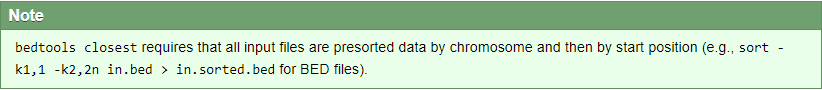

Trions le fichier <code>picVariant.bed</code>.

L'output est à stocker dans un fichier nommé <code>picVariant_sorted.bed</code>

In [ ]:
# Tri selon les colonnes 1 et 2 (2 en ordre numérique)


Nous tentons un essai avec le paramètrage par défaut. Rediriger la sortie dans un fichier <code>DEgenes_closest_picVariant.bed</code>

In [ ]:
# Recherche des gènes les plus proches des pics


Combien avait-on de pics de Chip avec une mutation et combien obtient-on de gènes à proximité ?

In [ ]:
# Comptage des lignes


On obtient 8 gènes de plus que notre nombre initial de pic. En regardant de plus près, on voit que le premier pic est aux alentours des bases 713,000 alors que le gène est vers 3,000,000... 

In [ ]:
# Visualisation des deux premières lignes


La pertinence de l'impact d'une protéine fixée à l'ADN a plus de 3 millions de paire de base d'un gène se pose. Il serait plus pertinent de rechercher les pics situés à proximité immédiate des gènes DE (entre 2000 bases avant ou après un gène par exemple).

Quelle option peut-on utiliser pour obtenir l'information de la distance entre le pic et le gène ? Stockons l'information dans un fichier nommé <code>DEgenes_closest_picVariant_distance.bed</code>

In [ ]:
# Recherche des gènes les plus proches 


L'utilisation de l'option <code>-D b</code> permet de donner la distance par rapport aux gènes qui sont les seuls à avoir une information sur le brin (les pics étant non orientés).
Une valeur négative signifie que le pic est en amont du gène et en aval pour les valeurs positives.

A ce stade, nous avons l'information de la distance mais aucun filtre.

In [ ]:
# Visualisation des deux premières lignes


Il est alors possible de mettre une commande supplémentaire pour filter. On utilise le langage <code>Awk</code> 

N.B. : <code>Awk</code> est un langage à part entière, puissant mais qui peut être complexe de prime abord. Nous n'avons pas le temps de vous en expliquer toute la syntaxe mais de très bons sites l'ont fait, notamment [ici](https://connect.ed-diamond.com/GNU-Linux-Magazine/glmf-131/awk-le-langage-script-de-reference-pour-le-traitement-de-fichiers) et [là](https://www.shellunix.com/awk.html).

In [ ]:
# Recherche des gènes les plus proches et dans la zone définie entre [-2000; +2000]
bedtools closest -a picVariant_sorted.bed \
-b DEgenes.gff3 -D b | \
awk 'BEGIN{FS="\t"}{if($14>=-2000 && $14<=2000){print $0}}' \
> DEgenes_closest_picVariant_borne2000.bed

Rapide aperçu de la commande :

- <code>awk ''</code> : On définit que tout ce qui est entre guillemets simples correspond à du langage <code>awk</code> et non plus du <code>bash</code>.
- <code>BEGIN{FS="\t"}</code> : On définit le séparateur de nos colonnes, ici la tabulation <code>"\t"</code>
- <code>{if(\$14>=-2000 && \$14<=2000){print \$0}}</code> : Pour chaque ligne (donc chaque gène), on vérifie (<code>if</code>) si la colonne 14 (<code>\$14</code>), qui contient la distance, a une valeur comprise entre -2000 (<code>\$14>=-2000</code>) et (<code>&&</code>) +2000 (<code>\$14<=2000</code>) inclus. Si c'est le cas, on affiche (<code>print</code>) la ligne entière (<code>\$0</code>).
    
Affichons maintenant les deux premières lignes :

In [ ]:
# Afficher les deux premières lignes


On rapproche à nouveau ces données de la réalité biologique. Il est surement pertinent de ne regarder que les pics présents en amont des gènes DE. Pour cela, on change simplement les filtres sur la distance dans <code>awk</code>. 

A vous de jouer !

Rappel : Les bornes de la zone en amont se définissent ainsi [-2000;0[

On écrit dans un fichier <code>DEgenes_closest_picVariant_amont_gene_DE.bed</code>

In [ ]:
# Recherche des gènes les plus proches et dans la zone définie entre [-2000; 0[


Notre liste est devenue bien plus raisonnable, affichons entièrement ce fichier

In [ ]:
# Affichage des fichiers


## Bonus n°3

#### *Devine la commande*

Ce dernier bonus est l'occasion de voir des commandes qui peuvent être utiles mais que nous n'avons pas pu aborder précédemment 

#### *Alternative à grep -v*

Dans l'exercice, point D, on utilise <code>grep -v</code> pour extraire les coordonnées génomiques des gènes non DE.

Il était aussi possible de le faire avec la commande <code>intersect</code>.

Trouverez vous comment ?

Attention aux options !

L'option la plus importante pour cette question est donc l'option <code>-v</code>. 

Mais par défaut, <code>intersect</code> valide une intersection dès qu'il y a une base en commun entre les 2 régions. Comme ci-dessous :

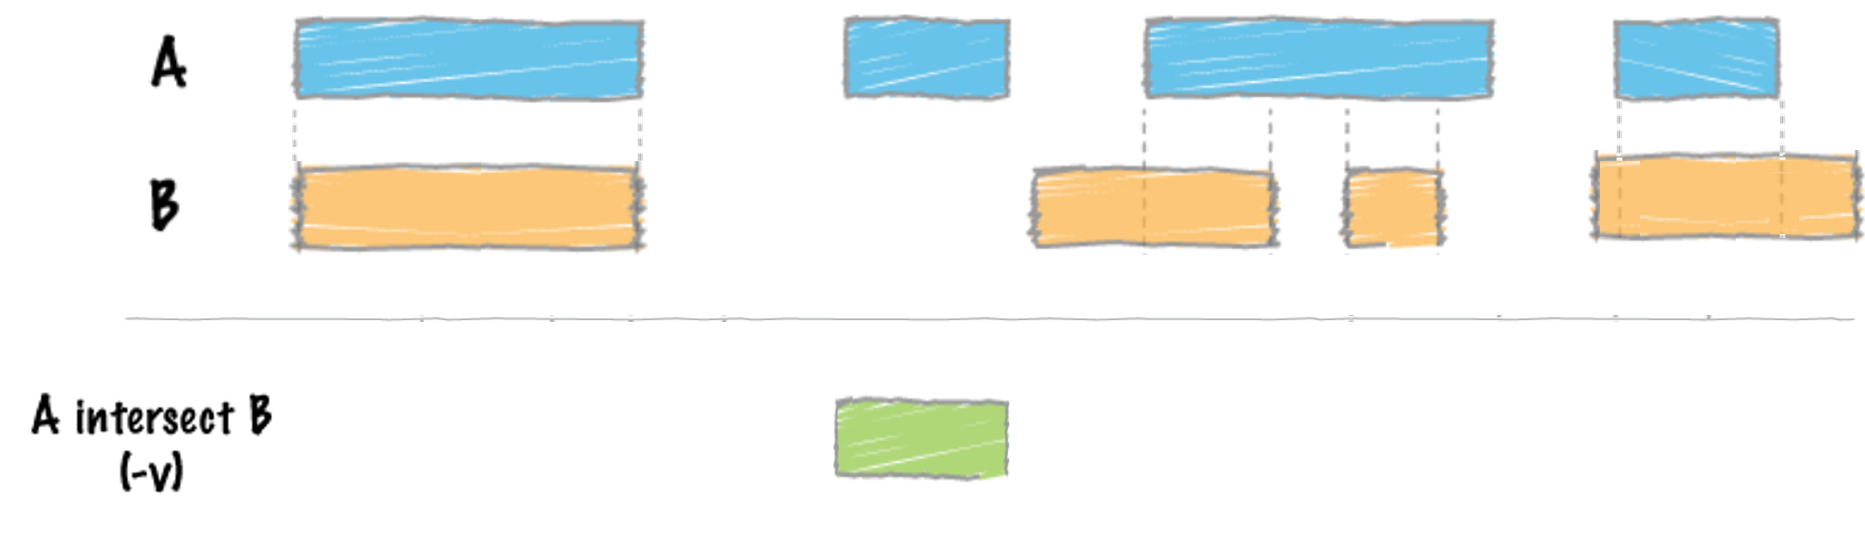

Dans ce cas d'usage où l'on traite des gènes en entier, il suffit que quelques gènes se chevauchent pour qu'ils soient exclus à tort. La façon correcte est donc de préciser que l'on veut valider les chevauchements que si les gènes se chevauchent à 100% entre eux. Les options pour spécifier un % de chevauchement (exprimés entre <code>[0-1]</code>, 1 pour 100%) sont <code>-F</code> pour le fichier A et <code>-f</code> pour le fichier B. Il faut aussi que les 2 gènes soient sur le même brin (option <code>-s</code>).

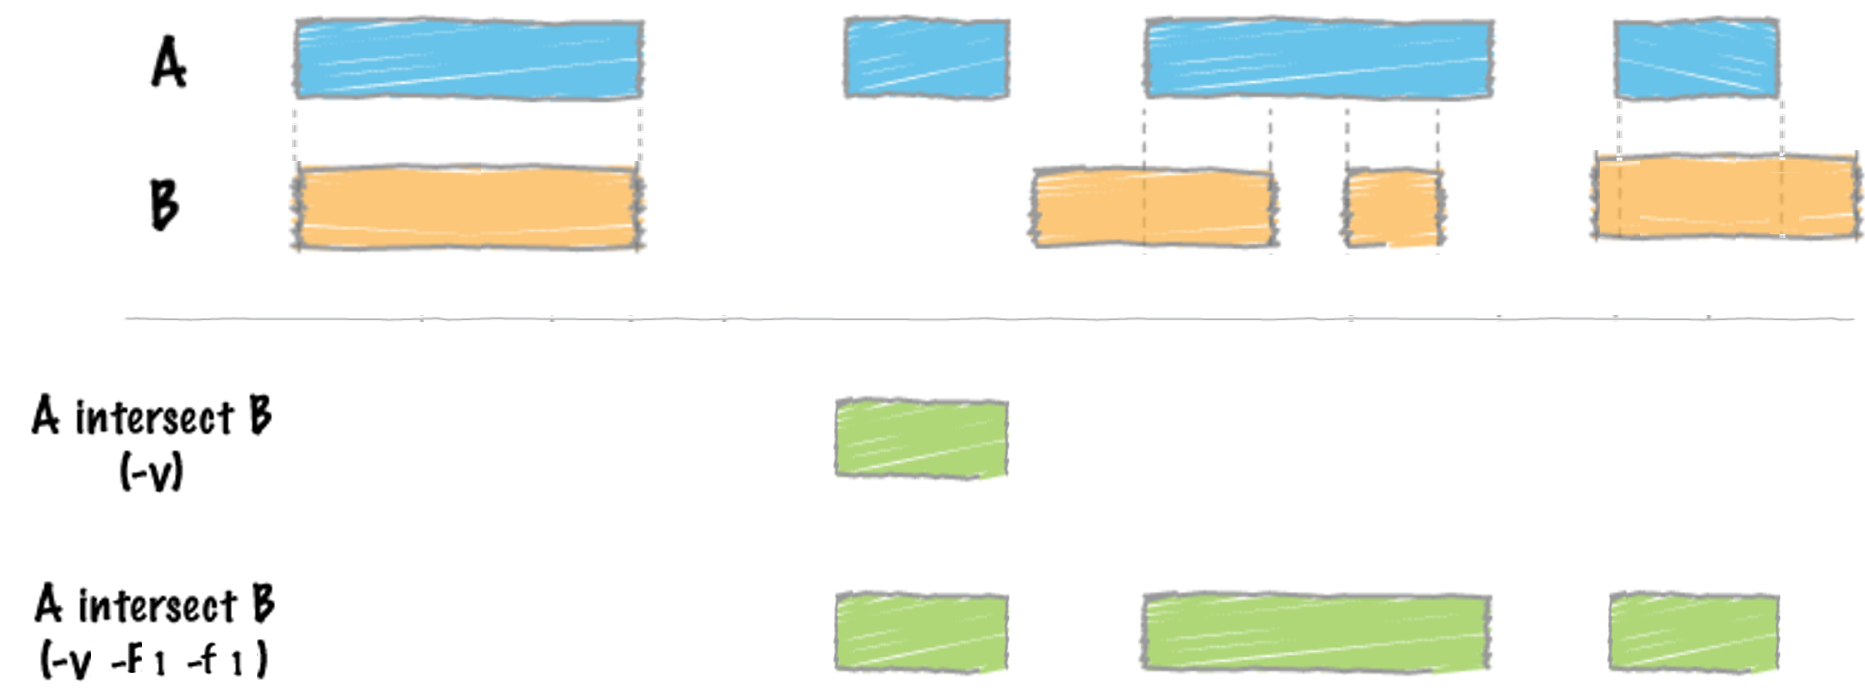

In [ ]:
# Intersection inversée

# Comptage des lignes
